In [1]:
from adam import ADAM
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
import numpy as np
from qiskit.quantum_info import Statevector
from math import log

In [2]:
# size of training data set
training_size = 100
# dimension of data sets
n = 2
from sklearn import datasets
from sklearn import preprocessing
iris = datasets.load_iris()
# load iris and normalise
x = preprocessing.normalize(iris.data)
x1_train = x[0:49, :] # class A
x2_train = x[50:99, :] # class B
training_input = {'A':x1_train, 'B':x2_train}
class_labels = ['A', 'B']

In [3]:
sv = Statevector.from_label('0' * n)

In [4]:
def final_circuit(circuit, data, params):
    angle_y = ((np.pi-data[0])*(np.pi-data[1]))
    angle_z = ((np.pi-data[2])*(np.pi-data[3]))
    for i in range(n):
        circuit.h(i)
        circuit.ry(data[i], i)
        circuit.rz(data[i+2],i)
    circuit.cx(0,1)
    circuit.ry(angle_y, 0)
    circuit.rz(angle_z, 1)
    circuit.cx(0,1)
    for i in range(n):
        circuit.ry(params[i],i)

In [5]:
def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

def return_probabilities(counts, class_labels):
    shots = sum(counts.values())
    result = {class_labels[0]: 0,
              class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key]/shots
    return result

def classify(x_list, params, class_labels):
    qc_list = []
    for x in x_list:
        circuit = QuantumCircuit(n)
        circ_ = final_circuit(circuit, x, params)
        qc = sv.evolve(circuit)
        qc_list += [qc]
    probs = []
    for qc in qc_list:
        counts = qc.probabilities_dict()
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs


def CrossEntropy(yHat, y):
    if y == 'A':
      return -log(yHat['A'])
    else:
      return -log(1-yHat['A'])


def cost_function(training_input, class_labels, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for label, samples in training_input.items():
        for sample in samples:
            training_labels += [label]
            training_samples += [sample]

    # classify all samples
    probs = classify(training_samples, params, class_labels)

    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        cost += CrossEntropy(yHat=prob, y=training_labels[i])
    cost /= len(training_samples)

    # return objective value
    #print(cost)
    return cost


# setup the optimizer
optimizer = ADAM(maxiter=100, lr=0.1)

# define objective function for training
objective_function = lambda params: cost_function(training_input, class_labels, params, print_value=True)

d = 2  # num of trainable params
for i in range(100):
    np.random.seed(i)
    # randomly initialize the parameters
    init_params = np.random.uniform(-1,1,2)
    print(init_params)
    # train classifier
    #init_params = np.random.uniform(-1,1,2)
    opt_params, value, _, loss = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
    print(loss)
    print(opt_params)
    # print results
    f1 = 'Layer1Hard/quantum_loss_hard_layer1_%d.npy' %i
    f2 = 'Layer1Hard/opt_params_hard_layer1_%d.npy'%i
    np.save(f2, opt_params)
    np.save(f1, loss)

[0.09762701 0.43037873]
[0.7782902770889429, 0.709627518154059, 0.6422543432140232, 0.5785294759842179, 0.5203636452613801, 0.4692312967129147, 0.4261762469145681, 0.39181000219272544, 0.3663038762866857, 0.34937991928703876, 0.34031214607695265, 0.33795548116792207, 0.34082078566181473, 0.34720528062756495, 0.3553679722698258, 0.3637174992319752, 0.3709694439065653, 0.37623980185640776, 0.3790649533333407, 0.37936137195478115, 0.3773492771374898, 0.3734625012405642, 0.3682601388252614, 0.3623481626459203, 0.3563136976269101, 0.3506730522275824, 0.3458335416821723, 0.34206931582533295, 0.3395114088864181, 0.3381518821591111, 0.3378613293171776, 0.3384175054070267, 0.339541598573103, 0.34093738567831106, 0.3423281379713793, 0.3434866228682128, 0.34425497736702465, 0.34455322268487937, 0.3443768389965125, 0.3437855072145126, 0.3428856539715707, 0.3418098904302816, 0.3406962377620176, 0.33966952171011255, 0.3388268739340722, 0.3382286028394524, 0.3378949694903257, 0.33780869184702833, 0.3

[0.9592774037031718, 0.901463324771069, 0.8364366798582001, 0.7676694025879096, 0.6983048800821158, 0.6311078898264033, 0.5684223384060315, 0.5121410827881389, 0.4636869190563565, 0.42399926825591755, 0.39352266332254643, 0.3721972579384069, 0.35945892637036486, 0.35426484179312756, 0.35516360819045917, 0.3604226234081286, 0.3682065119331308, 0.37677640533855417, 0.3846657645791734, 0.39079532546618817, 0.3945135811197073, 0.39557247145055896, 0.3940618745300882, 0.3903254820680774, 0.38487429175529064, 0.37830679628114844, 0.37123962703733737, 0.36425024131208866, 0.35783187706077185, 0.3523613856309817, 0.3480801851107301, 0.34508861613568975, 0.34335334732540074, 0.3427267296596191, 0.3429757412657305, 0.34381707396042216, 0.34495400728070574, 0.34611061825588335, 0.3470593657102553, 0.3476393659281968, 0.34776442850235584, 0.34742118888843226, 0.34665918376765115, 0.34557511987734457, 0.3442941162661697, 0.34295041578094976, 0.3416696892532932, 0.34055472323796687, 0.33967573908879

[0.9944515225522331, 0.9472532562753353, 0.8879990476749111, 0.8205777643221328, 0.7489671891698374, 0.6768705260663489, 0.6074945250201368, 0.5434474222942448, 0.48671457590979583, 0.4386729403082212, 0.4001180713612376, 0.3712905743865283, 0.3519013382005181, 0.34116475182515865, 0.33785514312378756, 0.34040123546559453, 0.3470246457353116, 0.3559113127021981, 0.36538777487877044, 0.3740673441015235, 0.38093964969397875, 0.3853963945704256, 0.3872035904543054, 0.38644023103700775, 0.3834223047189615, 0.3786257173289006, 0.37261514938042284, 0.3659819425885064, 0.3592916292629082, 0.35304146659116187, 0.3476278562784558, 0.3433246657996584, 0.3402729377272836, 0.33848247423944433, 0.3378451212660747, 0.33815837531811416, 0.3391567609033186, 0.34054719226338404, 0.34204397472431114, 0.3433991119030658, 0.34442458032607726, 0.34500466322806816, 0.34509811186510986, 0.3447312419002112, 0.34398428543842363, 0.3429734326448908, 0.34183145462329045, 0.34068916361384605, 0.33965976231985756,

[0.5864710392002925, 0.5295918556636107, 0.4803934770076758, 0.43986794949092534, 0.40850472113637865, 0.3862148890432655, 0.3722373062436356, 0.3651120092458849, 0.36284960975790936, 0.3633332016489433, 0.3647666441388753, 0.3659179618730364, 0.3661095856422388, 0.3650846715367951, 0.36286931984480764, 0.3596715879512874, 0.35581148995371287, 0.35166684786937413, 0.34762543046541294, 0.34404035351996304, 0.3411905287636255, 0.3392497413588019, 0.33826875307845605, 0.33817416872606076, 0.33878570768802585, 0.3398502751729694, 0.3410871019473203, 0.34223495660234626, 0.34309162351074396, 0.3435382963480499, 0.34354593182472926, 0.34316508217551245, 0.342504130206279, 0.3417014738137992, 0.34089744225300134, 0.3402101438644074, 0.33971842438162325, 0.3394536974073667, 0.33940093867924087, 0.3395078339826693, 0.3396997028032604, 0.3398968438221033, 0.34003074822350027, 0.3400560436449862, 0.3399562878468325, 0.33974321113811573, 0.33945039182084114, 0.33912338138787235, 0.3388088111192421

[0.46581412499353025, 0.42311833467767523, 0.38926076001983506, 0.36462885824882896, 0.3490782461724324, 0.34180772415385735, 0.34128353618549667, 0.3453337346791007, 0.35149657756373076, 0.357533145777714, 0.361855695305642, 0.36368615607290516, 0.3629615828286838, 0.3601190158691114, 0.3558701477475651, 0.35101589305712905, 0.34630910886687405, 0.3423582591614216, 0.33956505046198304, 0.33809388687361025, 0.3378746039270138, 0.33864003010084626, 0.3399948082150533, 0.3415033993927064, 0.34277796316347947, 0.34354594801552235, 0.343684263961323, 0.34321777688397687, 0.3422892353998667, 0.34111217842072156, 0.3399188708421489, 0.3389127991634917, 0.33823298541069236, 0.33793471238133177, 0.3379887650360188, 0.33829797312927895, 0.33872658331058836, 0.33913496579815317, 0.3394112069268288, 0.3394923663300244, 0.339371612650843, 0.3390913224531675, 0.3387258512611933, 0.3383593797830914, 0.3380645841529157, 0.3378869653125368, 0.3378377282224527, 0.3378958862918454, 0.33801803507872846, 

[0.9214510304962236, 0.863092811145854, 0.7983829774234134, 0.7306650517485963, 0.6629548623191406, 0.5978907438210592, 0.5376918356747651, 0.4841289516129526, 0.43850624709603714, 0.40164847852485003, 0.37389018181339106, 0.3550683344603436, 0.34452752616958177, 0.34115377008601494, 0.34345448975945253, 0.3496936450912742, 0.35807159601285027, 0.36691753140685324, 0.3748521619000907, 0.38088802067858113, 0.38445793860404925, 0.38538381509807046, 0.38380837431206555, 0.38011098228265583, 0.374822798080815, 0.36854916389567144, 0.36190228731509244, 0.35544574435228715, 0.34965131492255347, 0.3448685103030156, 0.3413074547692169, 0.3390355198996448, 0.3379873366937079, 0.33798693161677534, 0.3387794022556432, 0.3400681432021343, 0.3415529515019728, 0.3429641723904325, 0.344088955967978, 0.34478723896546337, 0.3449967760377919, 0.34472814886082326, 0.34405204447601534, 0.34308134512998334, 0.3419509434617429, 0.3407978523549261, 0.3397438734465404, 0.33888237390490683, 0.33827022112322314

[1.0195165159774133, 0.978394182380057, 0.9254867287755549, 0.8639655606144907, 0.7970643257709473, 0.727899683943061, 0.6593469777096111, 0.5939534594890825, 0.5338768492369237, 0.4808423170907979, 0.4361118928624634, 0.4004613090890755, 0.3741612907983303, 0.35696613937374666, 0.34812005436434335, 0.3463975074361582, 0.3501948475403675, 0.35767954984501643, 0.36698280738716127, 0.3763995433686879, 0.3845519758691826, 0.3904849397489021, 0.39368567923906433, 0.3940430417793163, 0.39177026457923503, 0.38731383118608226, 0.3812633235551979, 0.37427026198751606, 0.36697911162846375, 0.35997168750176434, 0.35372506390829683, 0.3485834051871644, 0.3447439195798362, 0.34225681969298916, 0.3410385408312377, 0.34089654974953515, 0.3415627329882043, 0.3427313226683397, 0.34409671272916564, 0.3453866765086, 0.3463874362172757, 0.34695852408945393, 0.3470370606191013, 0.34663258905983124, 0.34581438558188626, 0.3446940301249997, 0.34340577982810133, 0.3420872329491913, 0.34086229900846, 0.339828

[0.8047299756134352, 0.7346586880317997, 0.6655736426911958, 0.5999103451472816, 0.5396409011712686, 0.48629600949706103, 0.44097657946437085, 0.40435551472449216, 0.3766717811662938, 0.35772130859957113, 0.3468550997876314, 0.343000956348385, 0.3447273524448547, 0.35036131337908216, 0.35815460608062255, 0.3664702932250338, 0.37394768765997877, 0.3796097625730956, 0.38289828061361036, 0.38364535955477613, 0.38200409544558883, 0.37836108524466355, 0.37324795141526557, 0.36726111884370793, 0.36099383675925983, 0.35498170891230363, 0.3496618961788151, 0.34534612009593674, 0.34220736971740046, 0.3402803290431952, 0.3394748573040288, 0.33960067525739723, 0.3404003473978624, 0.34158641859857225, 0.3428779493455745, 0.3440319020616259, 0.34486589538512363, 0.34527048720592357, 0.3452108539676474, 0.34471921835912817, 0.3438804532160321, 0.3428134831161202, 0.34165139266700634, 0.34052256634778644, 0.33953498076319716, 0.3387650425310049, 0.3382518080493453, 0.3379967133004021, 0.3379683363213

[0.7868487039316298, 0.7178209155782886, 0.6504976320291489, 0.5872511101860348, 0.5299836474363584, 0.48013326962039027, 0.43867692726792196, 0.4061271484293433, 0.3825215289532209, 0.36741298422515956, 0.35987788170680163, 0.3585664871891306, 0.36181622555012605, 0.3678282800692863, 0.374876936812471, 0.3814995533741652, 0.38662087833755315, 0.38959476738615323, 0.39017645302470505, 0.3884522673645896, 0.3847525687176969, 0.3795646212032279, 0.3734536926965031, 0.3669955158146787, 0.3607210298408105, 0.35507379004073253, 0.3503800778570411, 0.3468323780291506, 0.34448637756384987, 0.34327125202009234, 0.34301191581928164, 0.34346056269764796, 0.3443335428568115, 0.3453487069925378, 0.34625837942537463, 0.346874018406092, 0.34708022409332406, 0.3468376129517162, 0.34617582352282944, 0.34517904200564087, 0.34396692607892226, 0.3426738585460539, 0.3414292991572983, 0.3403414025543996, 0.3394853915661743, 0.3388977187200881, 0.3385761091280309, 0.33848491288064175, 0.33856452998709635, 0

[0.8307047169168611, 0.760957127408316, 0.6911068739304508, 0.6237838562462392, 0.56114486241031, 0.5048978168068609, 0.4563154487611522, 0.41623993069986537, 0.3850797334484178, 0.36280190119449934, 0.34892750279482143, 0.3425437903047692, 0.3423510218351901, 0.34675854978165194, 0.354032152808697, 0.3624738274551765, 0.3705971806375645, 0.3772593525016324, 0.38172530495385815, 0.3836646418678235, 0.3830982151572169, 0.38031759717236724, 0.37579737818027287, 0.3701117117737584, 0.36386170137932317, 0.3576154265181802, 0.35186131807813315, 0.3469749924962795, 0.34319942800045505, 0.340638778638206, 0.3392652697942933, 0.33893814825817775, 0.3394323339613791, 0.34047329831063156, 0.3417738219853786, 0.34306799109337616, 0.3441384636730051, 0.34483429126861914, 0.34507831196473004, 0.3448647020871749, 0.34424840948874647, 0.343329069667053, 0.34223199868859966, 0.34108891478604975, 0.34002049799753525, 0.3391227068445903, 0.3384578091548351, 0.33805076376602994, 0.3378908700621823, 0.337

[0.3754044183122978, 0.3585676108500956, 0.3511071383000929, 0.3508948061045588, 0.35406634174349777, 0.3568978214650414, 0.3575300806278572, 0.35581410701581734, 0.35249311794447497, 0.3485840426085569, 0.3450172420460722, 0.34243860915080976, 0.3411122349993341, 0.3409114187839921, 0.34140864362915696, 0.3420532516555027, 0.3423754969346975, 0.34213161653491914, 0.3413404229237573, 0.34022307552645664, 0.33909254738693234, 0.3382378938121263, 0.3378343155898544, 0.337898409172115, 0.33829874945599814, 0.33881708476286215, 0.33923599663176157, 0.33941621399989513, 0.33933319371805265, 0.3390645338002768, 0.3387418277059018, 0.33849081658884883, 0.3383834233143223, 0.3384175696909807, 0.33852920811224985, 0.3386284317689646, 0.3386417933133099, 0.33854187712070094, 0.3383533233527922, 0.3381361514549265, 0.33795656769452664, 0.3378588361738396, 0.33784976853070575, 0.33790099023429876, 0.3379662737971475, 0.33800458887218315, 0.3379975438103435, 0.3379537476124057, 0.3378997909654165, 

[0.637090019214042, 0.5762470442934743, 0.5227015845529576, 0.47763891747236514, 0.4417454923279835, 0.41515958482873233, 0.39739319616139823, 0.38727616960236755, 0.383025163505808, 0.382523813898308, 0.38374957136303706, 0.38512846390223465, 0.38566044040280056, 0.3848529603319473, 0.38258574619800695, 0.3789872162127537, 0.37434331552808053, 0.36903098555395547, 0.363465027836605, 0.3580524333151355, 0.3531522332567842, 0.3490423076038326, 0.34589555287686985, 0.34376807271361726, 0.3426010496874059, 0.3422368508386593, 0.3424476258341129, 0.3429724049652276, 0.3435567210692566, 0.34398798671860914, 0.34412088031820903, 0.3438892382748895, 0.34330402774715124, 0.3424396439460589, 0.34141235323087377, 0.3403553783089905, 0.33939472955477334, 0.33862931352576164, 0.3381177114340117, 0.3378730500239198, 0.3378660298195114, 0.33803491445851064, 0.33830016742510505, 0.33858065976030877, 0.33880823905158214, 0.3389380703392954, 0.3389531846504347, 0.3388631473992814, 0.3386978174166029, 0

[0.6986578990645489, 0.6313987366153844, 0.572998342625899, 0.5244715948050507, 0.48618926495684867, 0.45768537208320154, 0.4374137484437571, 0.422863725860094, 0.41139571401890207, 0.40119258301656086, 0.39146987969688196, 0.3821198876459601, 0.37332256921401713, 0.36531233159104054, 0.3582744088479086, 0.35231521115376463, 0.3474673694978922, 0.34370673201136387, 0.34096906592832577, 0.33916129480067403, 0.3381671614589882, 0.3378498779311687, 0.3380554103239812, 0.3386192299964953, 0.339377351315919, 0.34018030984931047, 0.34090705088320844, 0.3414753332201516, 0.34184615536773943, 0.3420213228285206, 0.3420350079946046, 0.3419414821880046, 0.34180151604728737, 0.341669897964181, 0.3415860160585662, 0.3415686462097116, 0.3416153558523128, 0.34170605913728125, 0.3418096424456344, 0.3418920019804584, 0.341923737779194, 0.3418859559542302, 0.34177315171099065, 0.3415929338868932, 0.3413629978644101, 0.34110637980185227, 0.3408461814584498, 0.34060098109257025, 0.3403818386857823, 0.340

[0.59914621774342, 0.5432913259636786, 0.49597426839003633, 0.45798409267627427, 0.42953288434188364, 0.41012024419363297, 0.398413881023129, 0.39234355665945414, 0.3895662736261014, 0.3880879775031419, 0.3866039783167587, 0.38445200545746844, 0.38140388387575047, 0.3774842470721782, 0.37286147753972787, 0.36778778039257815, 0.36256093239204984, 0.35749144634677466, 0.3528698657685131, 0.34893524484277316, 0.3458484666962747, 0.3436744009116894, 0.3423764938510755, 0.34182555884387084, 0.34182244015713653, 0.3421313471851721, 0.34251808496024094, 0.34278583484293745, 0.34280163491864307, 0.34250904705932356, 0.341926032240805, 0.34113016886360326, 0.34023571689695625, 0.339367531479823, 0.33863660432812537, 0.338121028043832, 0.33785503779863785, 0.3378272500613006, 0.3379876235205903, 0.3382611889949373, 0.33856525717040536, 0.3388262994730397, 0.33899296953561636, 0.33904287251865994, 0.33898242977548093, 0.3388407352620716, 0.3386595227515291, 0.33848186459258794, 0.3383422635215600

[0.874984084260121, 0.8067089757023959, 0.7369330187487216, 0.6686831103767151, 0.6045062666704473, 0.5464461762335081, 0.4960367905170646, 0.45430004129618123, 0.42173712070208513, 0.3983116083590148, 0.38343592800535514, 0.375988607493239, 0.3743994356975551, 0.37682555292090514, 0.3813972244357706, 0.38646299161572184, 0.39075768352179263, 0.3934606717709257, 0.39416528419756575, 0.39280266174187856, 0.3895547102295451, 0.38477388093629655, 0.3789142836186141, 0.3724734893797354, 0.365942989148495, 0.3597668717319072, 0.3543088392068135, 0.3498285154337057, 0.34646831995449073, 0.34425161085282163, 0.34309232191625744, 0.34281498913731967, 0.3431829755345657, 0.3439313695593465, 0.344800254688428, 0.3455639853853843, 0.34605294881546206, 0.3461656256506889, 0.3458705959568455, 0.3451995499233658, 0.34423350330514685, 0.3430849378522757, 0.3418785168571178, 0.34073298379862244, 0.3397461632764597, 0.3389845719003261, 0.3384783855781052, 0.3382218961614894, 0.33817884967961803, 0.3382

[0.37075296067691543, 0.3520406730949752, 0.3428812563886552, 0.3417905451934094, 0.34559993282225787, 0.3503324109598069, 0.3531105622230513, 0.35303502613432985, 0.3506300964904825, 0.34700659153221286, 0.34331056314771874, 0.34043358340498414, 0.33886908655428233, 0.33866350341604873, 0.3394663474417816, 0.3406874231877415, 0.3417225149878997, 0.3421569774239378, 0.3418654039968412, 0.34099045495988284, 0.3398421347497726, 0.3387714123972352, 0.3380571855616521, 0.33783070948730126, 0.3380516631465384, 0.33854072135680396, 0.3390571255773399, 0.3393908856847742, 0.33943249928964936, 0.3391956628096312, 0.33879181717951345, 0.33837452844645954, 0.33807798356524527, 0.33797128368542245, 0.3380421605517203, 0.33821296285993174, 0.3383798615712562, 0.33845754096147995, 0.33841055022316324, 0.3382602305331874, 0.33806790885599125, 0.33790439607016415, 0.33781978810406954, 0.33782559121298167, 0.33789506564046146, 0.3379798245881451, 0.3380337801533859, 0.33803292318721273, 0.337982538974

[0.5683399474394228, 0.5111769400664411, 0.4611453981848874, 0.41928025968227844, 0.38621469278954373, 0.3621472111530747, 0.3467946926844924, 0.33935104028653906, 0.33848692646198086, 0.34243446780958703, 0.34918284415620604, 0.3567592339461949, 0.3635129416615332, 0.36830904367694023, 0.370585219591557, 0.3702905058216645, 0.3677583649504823, 0.3635640606455822, 0.358394802119327, 0.3529440069377578, 0.34783025282020263, 0.34353914620712594, 0.3403867300058368, 0.33850409958489047, 0.3378436574172942, 0.3382063350306751, 0.33928663609277027, 0.34072895193211844, 0.3421858872467585, 0.34336873588642886, 0.34408217652241363, 0.34423930768240063, 0.3438575873723665, 0.34303937368036186, 0.3419428298910579, 0.34074899973723705, 0.3396302528073627, 0.3387242957037843, 0.3381167888454409, 0.33783409571714057, 0.3378464744426973, 0.3380802565401297, 0.33843625461195, 0.3388105597509084, 0.33911371347244673, 0.3392847744237689, 0.3392983099115752, 0.33916375095579887, 0.338918322014379, 0.33

[0.3465197429983057, 0.34486306588250215, 0.34664051802635854, 0.3467562958176629, 0.3448745685542484, 0.3422857458972506, 0.34022238504808205, 0.33928655962779247, 0.33932420894221327, 0.3396793395436753, 0.33972926326283853, 0.3392879885688678, 0.3386028509795489, 0.3380857696436231, 0.3380218997338377, 0.3383988472109944, 0.3389350456146162, 0.33929173435751847, 0.3393009009173912, 0.33903228482834874, 0.33869206555747244, 0.33846490753671904, 0.33840561019964754, 0.33843382024523333, 0.3384201357588156, 0.3382918610379385, 0.33808054589826403, 0.3378878970087226, 0.337806521420647, 0.3378545593093091, 0.3379686690476403, 0.3380573586927194, 0.3380694395875049, 0.33802243337683485, 0.33797433068103244, 0.33796940913015566, 0.3380038447091152, 0.3380354862022434, 0.33802448430595344, 0.33796728050219565, 0.33789625574075094, 0.3378498072455148, 0.3378414303939122, 0.3378536713277498, 0.3378589578411533, 0.33784572006057256, 0.33782588418027826, 0.33781950920479104, 0.3378337674012975

[0.5259261321863758, 0.476908225961685, 0.4365746207648696, 0.4054797982443956, 0.3835833290913872, 0.37009773799808204, 0.36341628045253926, 0.3613318902594199, 0.36159063357871984, 0.36243605554131353, 0.3627966545769343, 0.3621706056961439, 0.3604381276477119, 0.35771984113362604, 0.3542870587968703, 0.35049834935606533, 0.3467443663521881, 0.3433950535859401, 0.3407507756768377, 0.3390024448790143, 0.3382068094020405, 0.3382823065133389, 0.3390285041690429, 0.3401674032451029, 0.3413986012825522, 0.34245561741618297, 0.3431499526967302, 0.3433937980145454, 0.34319938362413877, 0.3426593473673855, 0.34191553150039194, 0.3411242762424048, 0.3404247233574358, 0.3399150147933454, 0.3396392961628855, 0.33958659522257456, 0.3397006607006721, 0.3398978637075764, 0.3400887824111965, 0.3401984434763909, 0.34018086732196084, 0.34002530681436466, 0.3397538114290076, 0.33941176675429857, 0.3390545763270197, 0.3387338775073501, 0.3384865024609856, 0.3383283178018365, 0.33825375089036686, 0.3382

[0.7216028070615201, 0.6545343285007084, 0.5910756635483636, 0.5332658066732335, 0.4826584931406392, 0.44032707724887443, 0.40685833990823583, 0.3823317034991861, 0.3662936778076576, 0.3577541871685617, 0.35524706653459437, 0.35698888488503455, 0.3611251260945863, 0.3659917539607576, 0.37030258193499505, 0.3732190078704316, 0.3743221949483439, 0.3735354991115323, 0.3710354458072512, 0.3671696969344436, 0.3623863648915242, 0.3571734261331034, 0.35200661070644473, 0.34730554996803586, 0.34339880473899487, 0.3404994641701397, 0.33869319354128724, 0.33794008354708366, 0.33809051424596365, 0.3389134360075608, 0.3401333302243899, 0.3414703084273662, 0.34267705006888816, 0.34356704677895944, 0.3440305438429582, 0.3440375083858828, 0.3436289757384014, 0.34289992292839605, 0.3419775528930515, 0.3409984242569907, 0.3400877293024078, 0.339343042883132, 0.3388240374967985, 0.3385489124118434, 0.33849730763169866, 0.3386186326755581, 0.338844030211064, 0.33909973834528057, 0.3393195683739539, 0.339

[0.7491531322600863, 0.6808265037927359, 0.6148268143343418, 0.5533159370579809, 0.49801505758875186, 0.45021552353675337, 0.4107820079788384, 0.3801473652553774, 0.3583014709446933, 0.3447820293169171, 0.33868210178968006, 0.33869446951589216, 0.343210128410675, 0.35047359485712254, 0.35877400163908446, 0.3666304117969687, 0.3729275386825066, 0.3769768770841256, 0.3785051566258898, 0.377591434979201, 0.37457856613148616, 0.369979904806063, 0.36439290800278246, 0.35842519502297276, 0.35263471724669393, 0.34748413791780214, 0.3433096288522132, 0.34030423444978697, 0.3385159567009311, 0.3378601063183834, 0.338144386663797, 0.3391036291558298, 0.3404396507697025, 0.3418608799628375, 0.34311648193558786, 0.34402100907181954, 0.34446728740775723, 0.3444276049783978, 0.343944710506955, 0.3431153473158846, 0.34206961956503157, 0.34094912427434254, 0.33988675104066396, 0.3389902632037545, 0.3383312228008241, 0.3379400211580614, 0.33780708614165794, 0.3378894707715837, 0.3381214015801661, 0.338

[0.358715882745496, 0.3458647884358681, 0.3418634812234767, 0.3435896607440582, 0.3466757466663481, 0.3482334160447622, 0.3475426281935291, 0.3451799676201256, 0.3421945802847091, 0.3396003531416724, 0.3380888041441039, 0.33788004895173124, 0.338705797457542, 0.3399599324606493, 0.3409883479973937, 0.341370671518889, 0.34104115473233226, 0.3402287358361093, 0.3393015859690354, 0.338603562067581, 0.33833234124529765, 0.338485646825976, 0.3388877507810034, 0.33928470386377013, 0.33946389819637396, 0.3393397926815645, 0.33897043007376504, 0.3385095958577921, 0.3381275153716994, 0.3379371297212792, 0.3379542148733603, 0.33810406020851874, 0.3382677771464937, 0.3383433306961535, 0.3382904227134987, 0.33813965379859456, 0.33796690396528206, 0.33785001585393626, 0.33783045141264334, 0.33789727306302625, 0.33799898677222034, 0.3380746017314766, 0.33808580374614594, 0.3380331724499321, 0.3379498384210043, 0.33787916245775307, 0.33785026766842485, 0.3378646468743175, 0.3378996653312036, 0.337924

[0.7088356303832787, 0.6408249441048383, 0.5769889385252591, 0.519109869311713, 0.4685486710884663, 0.42625519719112726, 0.3927649297354019, 0.368184452254959, 0.3521731801975075, 0.3439354840426917, 0.34224532783781575, 0.34552633564215945, 0.35199843820792454, 0.3598759741490198, 0.36757428735846276, 0.37387189333710225, 0.37799253146583384, 0.3796034219937406, 0.37875206056962063, 0.3757714684011288, 0.37117883799301976, 0.3655819571747399, 0.3596000582938127, 0.3538003857197277, 0.3486508212321496, 0.344487944199773, 0.34150066712140276, 0.33972918388542245, 0.33907884865628257, 0.3393471518270334, 0.34026044628596114, 0.3415155883564061, 0.3428207587574714, 0.34392998863890745, 0.3446672284863683, 0.34493793320424526, 0.34472842360628103, 0.3440948890088746, 0.3431451104966884, 0.34201641801062377, 0.34085297461439223, 0.3397854149639459, 0.338914861622342, 0.33830289960403953, 0.33796810511198877, 0.337889008616582, 0.33801240711065544, 0.3382653619141833, 0.33856870634321257, 0.

[1.0208790403733927, 0.9814996648472019, 0.9299645051565294, 0.869389234473625, 0.8030077981512885, 0.733951687482606, 0.6651176223008542, 0.599082613172988, 0.538045439572207, 0.48378489631265464, 0.43762931145909006, 0.4004325529561193, 0.37255409620212765, 0.353845129693926, 0.3436494304965873, 0.34083428793049897, 0.3438688797662855, 0.3509596883034771, 0.3602341343921365, 0.3699412993657077, 0.3786263672204591, 0.3852427072899907, 0.38918790925536967, 0.39027436054377823, 0.38865747141020507, 0.38474536232698087, 0.3791070967814278, 0.37238887719144675, 0.3652423844263083, 0.35826645612784497, 0.35196244041958846, 0.3467034283254427, 0.34271741226526165, 0.3400844527746402, 0.33874724233546216, 0.3385336279455678, 0.3391883969874896, 0.3404105071589157, 0.3418912135136405, 0.34334854110207524, 0.34455424839661103, 0.34535097870038045, 0.3456587921211496, 0.3454718926599087, 0.3448474197134492, 0.3438889501350317, 0.34272712564897817, 0.3415001181772263, 0.34033600736858527, 0.3393

[0.7752528463002586, 0.7041578671610764, 0.6368311818986564, 0.5754995425796461, 0.5218271159598932, 0.47693416401069505, 0.4413800359135979, 0.41510299416410346, 0.3973423622370887, 0.38662869601850486, 0.38097114457631853, 0.3782741830740991, 0.3767934673007226, 0.3753739821751464, 0.3734200067058741, 0.37073239388648555, 0.367345764691494, 0.36341643626427383, 0.3591586663693607, 0.3548107343974006, 0.35061428181693377, 0.346797026833952, 0.34355508077836605, 0.34103498391286413, 0.33931805661801706, 0.3384105421695148, 0.33824231827072465, 0.338675947387587, 0.3395256305616556, 0.34058338277516587, 0.34164788796094525, 0.3425507118968717, 0.34317519266857954, 0.3434652903444305, 0.3434240914965239, 0.34310361829556757, 0.3425890245924293, 0.3419804038874055, 0.3413752017172704, 0.34085374581470124, 0.3404693812241929, 0.3402440395244116, 0.3401693006824881, 0.3402121220978982, 0.34032387380835605, 0.3404508398520293, 0.34054425706129093, 0.34056818136726763, 0.34050406842131975, 0.

In [7]:
loss_eqnn_d1 = np.load('Layer1Hard/quantum_loss_hard_layer1_1.npy')

In [8]:
loss_eqnn_d1.shape

(100,)

In [10]:
loss = np.zeros((100,100))
for i in range(100):
    file = 'Layer1Hard/quantum_loss_hard_layer1_%d.npy'%i
    loss[i] += np.load(file, allow_pickle=True)

In [11]:
loss.shape

(100, 100)

Text(0.5, 1.0, 'Training - 1 Layer (Data Reuploading, Qubits = 2, Hard Model)')

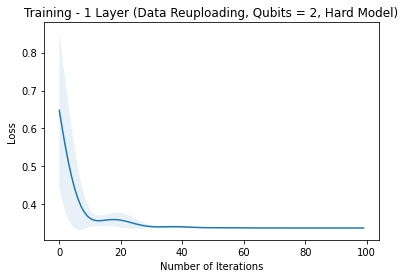

In [12]:
import matplotlib.pyplot as plt
groen = np.array([0,208,0])/255
stddevs =[]
averages =[]
sd = np.std(loss, axis=0)
av = np.average(loss, axis=0)
plt.plot(range(100), av)
plt.fill_between(range(100), av+np.array(sd), av-np.array(sd), alpha=0.1)
stddevs.append(sd)
averages.append(av)

plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Training - 1 Layer (Data Reuploading, Qubits = 2, Hard Model)")

In [13]:
losseasy = np.zeros((100,100))
for i in range(100):
    file = 'Layer1Easy/quantum_loss_easy_layer1h_%d.npy'%i
    losseasy[i] += np.load(file, allow_pickle=True)

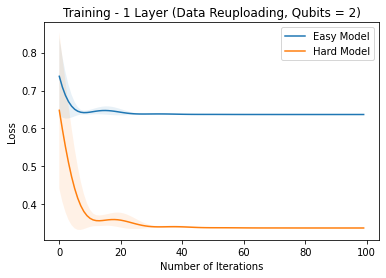

In [16]:
stddevs =[]
averages =[]
sde = np.std(losseasy, axis=0)
ave = np.average(losseasy, axis=0)
plt.plot(range(100), ave)
plt.fill_between(range(100), ave+np.array(sde), ave-np.array(sde), alpha=0.1)
stddevs.append(sde)
averages.append(ave)

plt.plot(range(100), av)
plt.fill_between(range(100), av+np.array(sd), av-np.array(sd), alpha=0.1)

plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Training - 1 Layer (Data Reuploading, Qubits = 2)")

legendList = ['{}'.format(i) for i in ["Easy Model", "Hard Model"]]
plt.legend(legendList)